# InvestBot: a bot for stock classification using fundamentalist analysis

InvestBot is a decision support tool for investors. It consists of classifying stocks on the stock exchange as a reliable investment or not to buy at that particular time, based on the following criteria:

- if the stock price will yield 3% or more until the next quarter

That is, a stock will be classified as reliable if it yields 3% or more. If the stock depreciates, or yield less than 3%, it will be classified as unreliable. 

**An important question is: how will we predict if a stock will appreciate until the next quarter?**

Basically, we will use a very famous approach in the investment world: fundamental analysis. This technique aims to determine the intrinsic value of a company, and its growth potential. For this, it uses some data that are called fundamental indicators, and these can be found from the balance sheet and income statement of companies.

With the data from the indicators collected, and the classes of stocks already defined, following the criteria explained above, some classification models will be trained, in order that they can predict whether a stock will appreciate more than 3% until the next quarter.

However, a doubt may arise: **fundamental analysis is used for medium and long-term investments, so is it possible to analyze the data of fundamental indicators to determine if a stock will appreciate until the next quarter? Well, that's what we'll find out at the end of this work.** As the fundamental analysis makes it possible to discover the real value of a stock, it may be possible from it to determine whether a stock will appreciate in value until the next quarter.

**The main objective here is to build a tool that supports investors' decision making for short-term investments, helping him to determine whether an action is reliable to buy at any given time.**

In the next sections, each of the steps necessary for us to reach the desired result will be developed.

## Solution Proposal

To solve the problem, we will follow these steps:

- **0.0.** Data Collection.
- **1.0.** Data Description.
- **2.0.** Feature Engineering
- **3.0.** Data Filtering
- **4.0.** Exploratory Data Analysis
- **5.0.** Data Preparation
- **6.0.** Feature Selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter Fine Tuning
- **9.0.** Machine Learning Performance
- **10.0.** Deploy Model to Production

<p align='center'>
    <img src='img/bot.jpg'>
</p>

# 0.0 Imports

In this section we will import the libraries needed to get the solution.

In [72]:
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import plotly.express              as px
import os
import pickle
from sklearn.preprocessing         import StandardScaler, RobustScaler
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.model_selection       import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report, confusion_matrix, make_scorer, precision_score
from sklearn.metrics               import recall_score, accuracy_score, f1_score
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.neural_network        import MLPClassifier
from sklearn.ensemble              import RandomForestClassifier, AdaBoostClassifier
from pandas_datareader             import data as web


import warnings
warnings.filterwarnings("ignore")

## 0.1. Helper Functions

in this step, we'll document all the functions that will be used to solve the problem.

In [40]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
def collect_balances( fundamentals, files, companies ):
    
    for file in files:
        # collecting only the company name
        name = file[:-4]

        # Balance Sheet
        balance = pd.read_excel( f'Balances/{file}', sheet_name=0 )

        # Name of the company as a title in the first column
        balance.iloc[0, 0] = name

        # Make the first line a header
        balance.columns = balance.iloc[0]
        balance = balance.iloc[1:]

        # Make the first column an index
        balance = balance.set_index( name )

        # Cash Flow Statement
        cfs = pd.read_excel( f'Balances/{file}', sheet_name=1 )

        # Name of the company as a title in the first column
        cfs.iloc[0, 0] = name

        # Make the first line a header
        cfs.columns = cfs.iloc[0]
        cfs = cfs.iloc[1:]

        # Make the first column an index
        cfs = cfs.set_index( name )

        try:
            fundamentals[name] = balance.append( cfs )
            companies.append( name )
        except:
            cfs.columns = balance.columns
            fundamentals[name] = balance.append( cfs )
            companies.append( name )
        else:
            pass
        
def read_quotes( quotes ):
    
    # getting the file name
    files = os.listdir( "Quotes" )
    
    for file in files:
        name = file[:-4]
        quotes[name] = pd.read_csv( f'Quotes/{file}' ) 
        
def show_missing_values( columns ):
    # Start dictionary with all keys equal to zero
    nan_values = dict.fromkeys( columns, 0 )
    total_lines = 0

    for company in fundamentals:
        tabel = fundamentals[company]
        # Total rows to know the proportion of missing values in each column
        total_lines += tabel.shape[0]

        for column in columns:
            qnt_nan = pd.isnull( tabel[column] ).sum()
            # Dictionary with the amount of nan values in each column
            nan_values[column] += qnt_nan
        
    return nan_values, total_lines

def transform_to_percentage_changes( df ):
    
    companies = list( df['Company'].unique() )
    
    for i, company in enumerate( companies ):
        df_aux = df.loc[df['Company'] == company]
        
        print( company )
        print( i )
        
        for column in df:
            if column == 'Company' or column == 'Class':
                continue
            
            conditions = [
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] > 0 ),
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] < 0 ),
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] == 0 )
            ]
            
            values = [1, -1, 0]
            
            df_aux[column] = np.select( conditions, values, default=df_aux[column].diff() / df_aux[column].abs().shift() )
            df.loc[df['Company'] == company, column] = df_aux[column]
    
    return df

def rescaling( data ):
    rs = RobustScaler()
    data_aux = data.drop( ['Class', 'Company'], axis=1 )
    
    data_aux = pd.DataFrame( rs.fit_transform( data_aux ), data_aux.index, data_aux.columns )
    data_aux['Class'] = data['Class']
     
    return data_aux

def ml_metrics( y_test, y_pred, model_name ):
    print( f'Model: {model_name}' )
    
    report = classification_report( y_test, y_pred, target_names=['Not reliable', 'Reliable'] )
    print( report )
    
    cf_matrix = pd.DataFrame( confusion_matrix( y_test, y_pred ), index=['Not reliable', 'Reliable'], columns=['Not reliable', 'Reliable'] )
    sns.heatmap( cf_matrix, annot=True, cmap='Blues', fmt=',' )
    plt.show()
    
def cross_validation( model, X_train, y_train, model_name ):
    
    precision2_score = make_scorer( precision_score, labels=[1], average='macro' )
    recall2_score = make_scorer( recall_score, labels=[1], average='macro' )
    f1_2_score = make_scorer( f1_score, labels=[1], average='macro' )
    
    accuracy = cross_val_score( model, X_train, y_train, cv=5, scoring='accuracy' )
    precision = cross_val_score( model, X_train, y_train, cv=5, scoring=precision2_score )
    recall = cross_val_score( model, X_train, y_train, cv=5, scoring=recall2_score )
    f1 = cross_val_score( model, X_train, y_train, cv=5, scoring=f1_2_score )
    
    return pd.DataFrame( {
      'Model': model_name,
      'Accuracy': np.round( np.mean( accuracy ), 2 ).astype( str ) + '+/-' + np.round( np.std( accuracy ), 2 ).astype( str ),
      'Precision': np.round( np.mean( precision ), 2 ).astype( str ) + '+/-' + np.round( np.std( precision ), 2 ).astype( str ),
      'Recall': np.round( np.mean( recall ), 2 ).astype( str ) + '+/-' + np.round( np.std( recall ), 2 ).astype( str ), 
      'F1': np.round( np.mean( f1 ), 2 ).astype( str ) + '+/-' + np.round( np.std( f1 ), 2 ).astype( str ) }, index = [0] )

In [41]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

The data needed to build our InvestBot bot are as follows:

- Balance Sheet and Cash Flow Statement
- Stock prices

**1.** The balance sheets and cash flow statements of the companies will be used to calculate the fundamental indicators of the companies. They were previously collected on the website [Fundamentus](https://www.fundamentus.com.br/resultado.php), and they are in the folder "/Balances". From the data found in these spreadsheets, it will be possible to calculate the fundamental indicators of the companies.

**2.** The collection of quote data was done through the "pandas_datareader" library, where it searches for quotes on the [Yahoo Finances](https://br.financas.yahoo.com/) website. The period analyzed will be from 06/30/2011 to 03/31/2020.

### 0.2.1. Balance Sheet and Cash Flow Statement

As stated earlier, the quote data was collected manually and placed in the "/Balances" folder. Now, we're going to import the balance sheets from the folder and put them in a dictionary called fundamentals.

In [59]:
# # Collect balance sheet and cash flow statement
# fundamentals = {}
# files = os.listdir( "Balances" )
# companies = []

# collect_balances( fundamentals, files, companies )

In [60]:
# # Saving balances sheets
# with open( "Data/Fundamentals_initial.pkl", "wb" ) as fund:
#     pickle.dump( fundamentals, fund )

In [4]:
# Importing the balances sheets
with open( "Data/Fundamentals_initial.pkl", "rb" ) as fund:
    fundamentals = pickle.load( fund )

### 0.2.2. Stock Quotes

The first time, the quotes were collected and placed in the "/Quotes" folder as .csv files. With that, the "read_quotes" function was created in order to read the quotes from the folder.

In [62]:
# # Collect stock quotes
# quotes = {}

# for company in companies:
#     try:
#         quotes[company] = web.DataReader( f'{company}.SA', data_source='yahoo', start="06/30/2011", end="09/30/2021" )
#     except:
#         pass

In [63]:
# # Saving quotes
# for company in quotes:
#     quotes[company].to_csv( f'Quotes/{company}.csv' )

In [5]:
# Read stock quotes
quotes = {}
read_quotes( quotes )

### 0.2.2. Remove companies from the fundamentals that do not have quotes for the period collected

In [9]:
companies = list( fundamentals.keys() )

for company in companies:
    if company not in quotes:
        fundamentals.pop( company )

companies = list( quotes.keys() )

### 0.2.3. Remove companies that have empty quotes

In [10]:
for company in companies:
    if quotes[company].isnull().values.any():
        quotes.pop( company )
        fundamentals.pop( company )

companies = list( quotes.keys() )

### 0.2.4. Adding dates that don't exist in the quotes 

In [29]:
# Adding dates for quarters that do not exist in quote dataframes
for company in companies:
    # Putting quote date as dataframe index
    quotes[company] = quotes[company].set_index( "Date" )
    first_date = quotes[company].index[0].split( '-' )
    last_date = quotes[company].index[-1].split( '-' )
    
    for date in fundamentals[company].columns:
        try:
            date_aux = date.split( '/' )
        except:
            continue
        
        if datetime.date( int( date_aux[2] ), int( date_aux[1] ), int( date_aux[0] ) ) <= datetime.date( int( last_date[0] ), int( last_date[1] ), int( last_date[2] ) ) and datetime.date( int( date_aux[2] ), int( date_aux[1] ), int( date_aux[0] ) ) >= datetime.date( int( first_date[0] ), int( first_date[1] ), int( first_date[2] ) ):
            formatted_date = date_aux[2] + '-' + date_aux[1] + '-' + date_aux[0]
            # Inserting new lines with empty fields
            if formatted_date not in list( quotes[company].index ):
                quotes[company].loc[formatted_date] = np.nan

# Sorting the df and filling the created fields
for company in quotes:
    # sorting by date
    quotes[company] = quotes[company].sort_index()
    
    # filling empty fields with data from the previous row
    quotes[company] = quotes[company].ffill()


In [30]:
for company in quotes:
    quotes[company] = quotes[company].reset_index()
    quotes[company]['Date'] = pd.to_datetime( quotes[company]['Date'] )
    quotes[company]['Date'] = quotes[company]['Date'].dt.strftime( "%d/%m/%Y" )
    quotes[company] = quotes[company].set_index( 'Date' )
    quotes[company].index = pd.to_datetime( quotes[company].index, format="%d/%m/%Y" )

### 0.2.4. Joining the fundamentals and the quotes

In [36]:
for company in fundamentals:
    # Fundamentals
    # Turn rows into columns
    table = fundamentals[company].T
    
    # Transform index to date type
    table.index = pd.to_datetime( table.index, format="%d/%m/%Y" )
    
    # Quotes
    quote_table = quotes[company]
    
    # Select only the column Adj Close
    quote_table = quote_table[['Adj Close']]
    
    # Merge
    table = table.merge( quote_table, right_index=True, left_index=True )
    
    # Inserting name in index column
    table.index.name = company
    
    fundamentals[company] = table

### 0.2.5. Removing empty dataframes

In [50]:
companies = list( fundamentals.keys() )

for company in companies:
    if len( fundamentals[company] ) == 0:
        fundamentals.pop( company )

### 0.2.6. Treat columns

- Catch only companies that have the same columns
- Columns with repeated names
- Missing values
- Create a column with the name of the companies

**1. Catch only companies that have the same columns**

In [53]:
columns = list ( fundamentals['PETR4'].columns )
companies = list( fundamentals.keys() )

for company in companies:
    # Checking if the company has the necessary columns
    if set( columns ) != set( fundamentals[company].columns ):
        fundamentals.pop( company )

**2. Columns with repeated names**

In [55]:
# Changing the name of columns that have the same names
text_columns = ";".join( columns )

modified_columns = []
for column in columns:
    if columns.count( column ) == 2 and column not in modified_columns:
        text_columns = text_columns.replace( ";" + column + ";", ";" + column + "_1;", 1 )
        modified_columns.append( column )
        
columns = text_columns.split( ';' )

In [56]:
# Implement columns in tables
for company in fundamentals:
    fundamentals[company].columns = columns

**3. Missing values**

In [57]:
# Counting the total number of missing values in each column
nan_values, total_lines = show_missing_values( columns )
        
print( nan_values )
print( total_lines )

{'Ativo Total': 0, 'Ativo Circulante': 0, 'Caixa e Equivalentes de Caixa': 0, 'Aplicações Financeiras': 0, 'Contas a Receber_1': 0, 'Estoques_1': 0, 'Ativos Biológicos_1': 0, 'Tributos a Recuperar': 0, 'Despesas Antecipadas_1': 0, 'Outros Ativos Circulantes': 0, 'Ativo Realizável a Longo Prazo': 0, 'Aplicações Financeiras Avaliadas a Valor Justo': 0, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 0, 'Contas a Receber': 0, 'Estoques': 0, 'Ativos Biológicos': 0, 'Tributos Diferidos_1': 0, 'Despesas Antecipadas': 0, 'Créditos com Partes Relacionadas': 0, 'Outros Ativos Não Circulantes': 0, 'Investimentos': 0, 'Imobilizado': 0, 'Intangível': 0, 'Diferido': 0, 'Passivo Total': 0, 'Passivo Circulante': 0, 'Obrigações Sociais e Trabalhistas': 0, 'Fornecedores': 0, 'Obrigações Fiscais': 0, 'Empréstimos e Financiamentos_1': 0, 'Passivos com Partes Relacionadas_1': 0, 'Dividendos e JCP a Pagar': 0, 'Outros_1': 0, 'Provisões_1': 0, 'Passivos sobre Ativos Não-Correntes a Venda e Descontin

In [58]:
# Remove columns longer than 50 rows with nan values
delete_columns = []

for column in nan_values:
    if nan_values[column] > 50:
        delete_columns.append( column )
        
for company in fundamentals:
    fundamentals[company] = fundamentals[company].drop( delete_columns, axis=1 )
    fundamentals[company] = fundamentals[company].ffill()

**4. Create a column with the name of the companies**

In [59]:
for company in fundamentals:
    fundamentals[company].loc[:, 'Company'] = fundamentals[company].index.name

### 0.2.6. Creating labels: reliable or not reliable

**Rules:**

    1. The stock yielded 3% or more = reliable - Value 1
    2. The stock yielded lower than 3% = not reliable - Value 0

In [68]:
# transform quotes into percentages
# quarter quotes - next quarter quote / quarter quote - 1

for company in fundamentals:
    indicator = fundamentals[company]
    indicator = indicator.sort_index()
    
    # get next indicator
    indicator['Perc'] = ( indicator['Adj Close'].shift( -1 ) / indicator['Adj Close'] ) -1                                                                    
    indicator['Class'] = indicator['Perc'].map( lambda x: 1 if x >= 0.03 else 0 ) 
        
    fundamentals[company] = indicator

### 0.2.7. Making everything a single dataframe

In [70]:
# with open( "Data/Fundamentals_final.pkl", "wb" ) as fund:
#     pickle.dump( fundamentals, fund )

In [5]:
# with open( "Data/Fundamentals_final.pkl", "rb" ) as fund:
#     fundamentals = pickle.load( fund )

In [8]:
# Saving train and test datasets
df = pd.DataFrame()

for company in fundamentals:
    fundamentals[company] = fundamentals[company][:-1]
    fundamentals[company] = fundamentals[company].reset_index( drop=True )
    df = df.append( fundamentals[company] )
    
df.to_csv('Data/Fundamentals.csv', index=False )

# 1.0. Data Description

in this step we will perform the following tasks:

- Rename Columns
- Data Dimensions
- Data Types
- Change data types
- Check missing values
- Descriptive Statistical

This step is very important for us to know how challenging the problem is.

In [9]:
# Importing 
df1 = pd.read_csv( 'Data/Fundamentals.csv' )

df1.sample()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class
9790,7572805.12,758785.98,296099.01,49065.00,181712.99,91906.00,0.00,107852.00,24699.00,7452.00,598577.02,0.00,0.00,49968.00,0.00,0.00,0.00,160088.99,154632.00,233888.00,0.00,6179511.81,35930.00,0,7572805.12,1393810.05,159668.99,222768.99,150608.99,653491.01,3031.00,99261.00,80315.99,24664.00,0.00,2876186.88,2176357.12,16303.00,90675.00,270184.99,0,322667.01,0.00,0.00,0.00,3302808.06,1597362.05,0.00,0.00,1696528.00,0.00,8918.00,0.00,0.00,0,809851.90,-573771.90,236080.00,48246.00,-60372.01,0.00,71357.98,-126623.01,0.00,-65720.00,177547.01,-243267.01,102969.01,-90745.99,41808.00,54031.00,4.57,MRSA3B,0.00,0


## 1.1. Data Dimensions

In [10]:
print( f'Number of rows: {df1.shape[0]}' )
print( f'Number of columns: {df1.shape[1]}' )

Number of rows: 15254
Number of columns: 75


## 1.2. Data Types

In [11]:
df1.dtypes

Ativo Total                                                       float64
Ativo Circulante                                                  float64
Caixa e Equivalentes de Caixa                                     float64
Aplicações Financeiras                                            float64
Contas a Receber_1                                                float64
Estoques_1                                                        float64
Ativos Biológicos_1                                               float64
Tributos a Recuperar                                              float64
Despesas Antecipadas_1                                            float64
Outros Ativos Circulantes                                         float64
Ativo Realizável a Longo Prazo                                    float64
Aplicações Financeiras Avaliadas a Valor Justo                    float64
Aplicações Financeiras Avaliadas ao Custo Amortizado              float64
Contas a Receber                      

## 1.3. Check NA

In [12]:
df1.isna().sum().sort_values( ascending=False )

Resultado Bruto                                                   3
Receitas Financeiras                                              3
Receita Líquida de Vendas e/ou Serviços                           3
Custo de Bens e/ou Serviços Vendidos                              3
Despesas Com Vendas                                               3
Despesas Gerais e Administrativas                                 3
Perdas pela Não Recuperabilidade de Ativos                        3
Outras Receitas Operacionais                                      3
Resultado da Equivalência Patrimonial                             3
Financeiras                                                       3
Outras Despesas Operacionais                                      3
Despesas Financeiras                                              3
Resultado Antes Tributação/Participações                          3
Provisão para IR e Contribuição Social                            3
IR Diferido                                     

## 1.4. Fillout Na

In [13]:
df1.fillna( 0, inplace=True )

## 1.5. Descriptive Statistical

We will use two types of analysis:

- Central tendency
    - average
    - median
- Dispersion 
    - std - standard deviation
    - min
    - max
    - range
    - skew
    - kurtosis

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Ativo Total,0.00,1015142023.17,1015142023.17,16034854.21,2831757.44,67503428.35,10.29,121.13
1,Ativo Circulante,0.00,292852989.95,292852989.95,4420517.43,877996.03,14552441.06,9.11,107.88
2,Caixa e Equivalentes de Caixa,-30.00,106597998.59,106598028.59,1085782.25,95478.00,4963608.69,12.27,179.94
3,Aplicações Financeiras,0.00,142760001.54,142760001.54,637934.24,7379.00,3965626.77,24.60,740.04
4,Contas a Receber_1,0.00,115283001.34,115283001.34,1106478.90,232051.00,3904960.32,14.96,306.56
5,Estoques_1,-968.00,39729999.87,39730967.87,759040.79,36021.00,2863192.39,7.88,76.34
6,Ativos Biológicos_1,0.00,6490744.83,6490744.83,15806.48,0.00,181834.84,18.29,437.44
7,Tributos a Recuperar,0.00,29788000.26,29788000.26,232932.57,18561.22,1021374.34,11.71,197.40
8,Despesas Antecipadas_1,0.00,2270287.10,2270287.10,17277.19,0.00,101778.04,12.79,200.58
9,Outros Ativos Circulantes,-85.00,56051998.72,56052083.72,565111.92,25194.00,2666508.27,8.46,88.83


It seems that some lines have abnormal values, and this may affect the performance of our models. So, let's check which lines have these values, to eliminate them later.

In [179]:
list( df1.loc[df1['Adj Close'] == df1['Adj Close'].min(), 'Company'] )[0] 

'MMAQ3'

In [180]:
list( df1.loc[df1['Adj Close'] == df1['Adj Close'].max(), 'Company'] )[0]

'MMAQ3'

**The Company *MMAQ3* has abnormal values, and will be excluded from the dataset in section 3.0.**

# 2.0. Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
# Reading the dataset of the number of papers available
df_qnt = pd.read_csv( 'Data/quantity.csv' )

# merge
df2 = pd.merge( df2, df_qnt, how='inner', on=['Company'] )

# change data type
df2['quantity'] = df2['quantity'].astype( 'int64' )

In [17]:
# Liquidez Corrente
df2['Liquidez Corrente'] = df2[['Ativo Circulante', 'Passivo Circulante']].apply( lambda x: 0 if x['Passivo Circulante'] == 0 
                                                                else x['Ativo Circulante'] / x['Passivo Circulante'], axis=1 )
# LPA
df2['LPA'] = df2['Lucro/Prejuízo do Período'] / df2['quantity'] 

# P/L
df2['P/L'] = df2[['Adj Close', 'LPA']].apply( lambda x: 0 if x['LPA'] == 0 else x['Adj Close'] / x['LPA'], axis=1 )

# VPA
df2['VPA'] = df2['Patrimônio Líquido'] / df2['quantity']

# P/VP 
df2['P/VP'] = df2[['Adj Close', 'VPA']].apply( lambda x: 0 if x['VPA'] == 0 else x['Adj Close'] / x['VPA'], axis=1 )

# EBIT
df2['EBIT'] = df2['Receita Líquida de Vendas e/ou Serviços'] - df2['Custo de Bens e/ou Serviços Vendidos'] - ( df2['Despesas Com Vendas'] + df2['Despesas Gerais e Administrativas'] )

# EV/EBIT
df2['EV/EBIT'] = df2[['Adj Close', 'quantity', 'Empréstimos e Financiamentos_1', 'Ativo Circulante', 'EBIT']].apply( lambda x: 0 
                                                    if x['EBIT'] == 0 else ( ( x['Adj Close'] * x['quantity'] ) 
                                                                            + ( x['Empréstimos e Financiamentos_1'] 
                                                                            - x['Ativo Circulante'] ) ) 
                                                                            / x['EBIT'] , axis=1 )
# NOPLAT
df2['NOPLAT'] = df2['EBIT'] - df2['IR Diferido']

# ROIC
df2['ROIC'] = df2[['NOPLAT', 'Investimentos']].apply( lambda x: 0 if x['Investimentos'] == 0 else x['NOPLAT'] / x['Investimentos'], axis=1 )

# ROE
df2['ROE'] = df2[['Reservas de Lucros', 'Patrimônio Líquido']].apply( lambda x: 0 
                                                if x['Patrimônio Líquido'] == 0 
                                                else x['Reservas de Lucros'] / x['Patrimônio Líquido'], axis=1 )

# Pay-Out
df2['Pay-Out'] = df2[['Dividendos e JCP a Pagar', 'Lucro/Prejuízo do Período']].apply( lambda x: 0 
                                   if x['Lucro/Prejuízo do Período'] == 0 
                                   else ( x['Dividendos e JCP a Pagar'] / x['Lucro/Prejuízo do Período'] ) * 100, axis=1 )

# Dividend Yield
df2['Dividend Yield'] = ( ( df2['Dividendos e JCP a Pagar'] / df2['quantity'] ) / df2['Adj Close'] ) * 100

# Marg. Ebit
df2['MargEbit'] = df2[['EBIT', 'Receita Líquida de Vendas e/ou Serviços']].apply( lambda x: 0 
                                                        if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                                        else x['EBIT'] / x['Receita Líquida de Vendas e/ou Serviços'], axis=1 )

# Marg. Liquida
df2['MargLiquida'] = df2[['Lucro/Prejuízo do Período', 'Receita Líquida de Vendas e/ou Serviços']].apply( lambda x: 0 
                                  if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                  else x['Lucro/Prejuízo do Período'] / x['Receita Líquida de Vendas e/ou Serviços'], axis=1 )

# P/Ebit
df2['P/Ebit'] = df2[['Adj Close', 'EBIT']].apply( lambda x: 0 if x['EBIT'] == 0 else x['Adj Close'] / x['EBIT'], axis=1 )

# PSR
df2['P/Ebit'] = df2[['Adj Close', 'Receita Líquida de Vendas e/ou Serviços', 'quantity']].apply( lambda x: 0 
                                if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                else x['Adj Close'] / ( x['Receita Líquida de Vendas e/ou Serviços'] / x['quantity'] ), axis=1 )

# P/Ativos
df2['P/Ebit'] = df2[['Adj Close', 'Ativo Total', 'quantity']].apply( lambda x: 0 if x['Ativo Total'] == 0 
                                                            else x['Adj Close'] / ( x['Ativo Total'] / x['quantity'] ), axis=1 )

# 3.0. Data Filtering

In [21]:
df3 = df2.copy()

In this section, we'll filter out the rows and columns that are not needed or that could damage the model training. Therefore, we will separate this step into two:

**1.** Filtering Rows

**2.** Filtering Columns

## 3.1. Filtering Rows

As previously stated, here we will filter the lines of company **MMAQ3**, which have abnormal values. Also, we will also remove the lines that have the negative quotes, after all, it makes no sense for a quote to have a price lower than 0, right

In [22]:
df3 = df3.loc[ ( df3['Company'] != 'MMAQ3' ) & ( df3['Company'] != 'MMAQ4' ) &
               ( df3['Company'] != 'VSPT3' ) & ( df3['Adj Close'] > 0 ) ]   

## 3.2. Filtering Columns

Now, we are going to delete some columns that are no longer needed. These will be:

**1.** Adj Close - The quotes column was used only to label the stocks. However, right now, it will not help us.

**2.** quantity - the quantity of papers was useful to create other features, however, it will not be necessary to create the model.

In [24]:
df3.drop( ['Adj Close', 'quantity', 'Perc'], axis=1, inplace=True )

# 4.0.Exploratory Data Analysis

In [26]:
df4 = df3.copy()

In this section, in order to become more familiar with our data, we will have to perform some simple Exploratory Data Analysis. We do this to better understand our data and make sure there are no lingering issues we may have missed when we transformed the data. So let’s begin coding it out with some visualizations.

## 4.1. Response Variable

First, we'll build a countplot to see the number of observations for each class.

**As we can see, our data is a little imbalanced...**

0    59.02%
1    40.98%
Name: Class, dtype: object


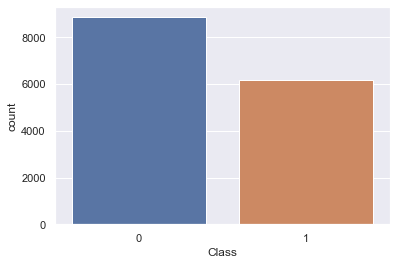

In [27]:
print( df4['Class'].value_counts( normalize=True ).map( "{:.2%}".format ) )
sns.countplot( x=df4['Class'] );

## 4.2. Multivariate Analysis

In [36]:
# transform
df4 = transform_to_percentage_changes( df4 )

# Delete Nan values
df4.dropna( inplace=True )

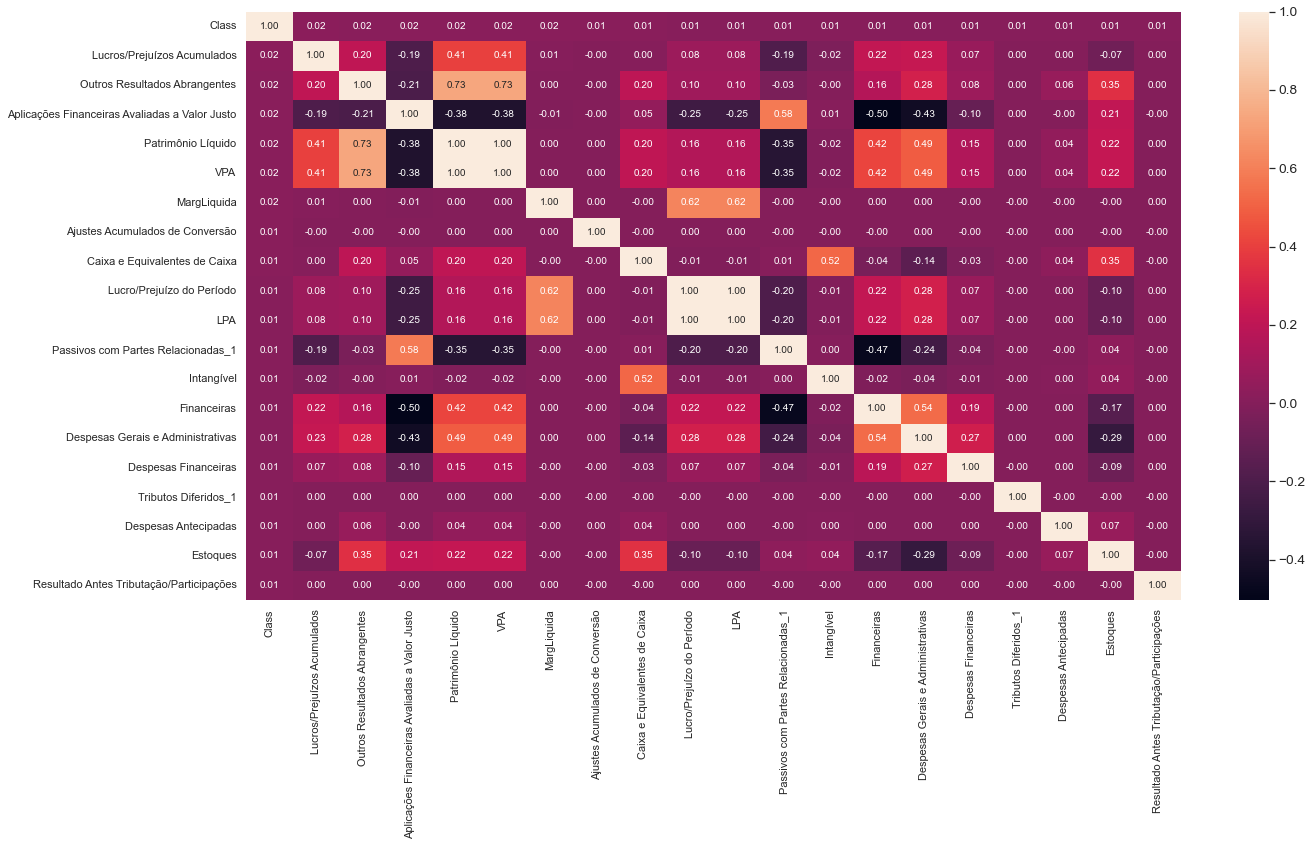

In [37]:
# correlations
k = 20
df_corr = df4.corr()
cols = df_corr.nlargest( k, 'Class' )['Class'].index
cm = np.corrcoef( df4[cols].values.T )

fig, ax = plt.subplots( figsize=(20, 12) )
sns.set( font_scale=1.25 )
hm = sns.heatmap( cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,  xticklabels=cols.values )
plt.tight_layout()

In [100]:
df4_aux['Date'] = df4['Date']

# 5.0. Data Preparation

in this section we will prepare the data so that it can be submitted to classification models. First, we will transform all indicators into percentage changes, similar to what we did with quotes. However, let's look backwards and see what the percentage change of an indicator has been from the previous quarter to the current one. We will do this for every quarter. The idea is to verify whether the increase or decrease of an indicator from the previous quarter to the current one can influence the appreciation or devaluation of the share price for the next quarter. In our case, we will see if the stock will appreciate more than 3% by the next quarter.

Later, we will scale the data to improve the overall performance of most of our models.

In [39]:
df5 = df4.copy()

## 5.1. Rescaling

In [42]:
df5 = rescaling( df5 )

In [44]:
# df5.to_csv( 'Data/df5.csv', index=False )

In [45]:
df5 = pd.read_csv( 'Data/df5.csv' )

# 6.0. Feature Selection

In [52]:
df6 = df5.copy()

## 6.1. Finding the best features

### 6.1.1. Based on Correlation Values

In [26]:
# Correlation of all classes
corr = df6.drop( 'Date', axis=1 ).corr().iloc[[-1], :-1]

# Sorting our correlations by their absolute values and selecting the top 10
top10_corr = corr.transpose().sort_values(by='Class', ascending=False)[:10]

df6[top10_corr.index].head()

,Lucros/Prejuízos Acumulados,Outros Resultados Abrangentes,Aplicações Financeiras Avaliadas a Valor Justo,Patrimônio Líquido,VPA,MargLiquida,Ajustes Acumulados de Conversão,Caixa e Equivalentes de Caixa,Financeiras,Despesas Financeiras
0,0.024054,-0.049928,-0.028022,0.008542,0.008542,-0.012815,-0.007638,-0.044556,0.027627,0.013527
1,0.024123,0.008691,-0.031411,0.009305,0.009305,-0.011694,-0.007638,-0.036897,0.009819,0.018785
2,0.037703,-0.025742,-0.025951,0.008610,0.008610,-0.005147,-0.007638,-0.036439,0.024545,0.018785
3,-0.002662,0.048419,-0.050660,0.007960,0.007960,-0.019843,-0.007638,-0.026441,0.017618,0.018785
4,0.030297,-0.049928,-0.035056,0.008573,0.008573,-0.004621,-0.007638,-0.039465,0.027110,0.018785


### 6.1.2. Based on a Tree Classifier

In [53]:
# let's train a decision tree and get the most important features of it
model = ExtraTreesClassifier( random_state=1 )
X = df6.drop( ['Class'], axis=1 )
y = df6['Class']
model.fit( X, y )

important_features = pd.DataFrame( model.feature_importances_, X.columns ).sort_values( by=0, ascending=False )
top10 = list( important_features.index )[:10]

top10.append( 'Class' )
df6[top10].head()

,EV/EBIT,P/Ebit,P/VP,P/L,Dividend Yield,Ativo Total,Lucros/Prejuízos Acumulados,Passivo Total,Patrimônio Líquido,Fornecedores,Class
0,0.26,0.18,0.18,1.32,0.00,0.25,0.29,0.25,0.02,-0.80,1
1,0.25,0.41,0.30,0.42,0.00,0.24,0.29,0.24,0.36,0.65,0
2,-0.25,-0.18,-0.19,-0.44,0.00,0.12,0.88,0.12,0.05,0.36,0
3,-0.06,-0.51,-0.51,-1.15,0.00,-0.34,-0.88,-0.34,-0.24,-0.00,1
4,0.23,0.39,0.26,2.05,0.00,-0.24,0.56,-0.24,0.03,-0.33,0


## 6.2. Split dataframe into training and test

In [55]:
df6 = df6[top10]

# df_test = df_test[top10_corr.index].join( df_test.Class )
# df_train = df_train[top10_corr.index].join( df_train.Class )

X = df6.drop( 'Class', axis=1 )
y = df6['Class']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=13 )

# 7.0. Machine Learning Modeling

Logistic Regression, Decision Tree, K-Nearest Neighbors, Naive Bayes and Multilayer Perceptron

## 7.1. Baseline

Model: Dummy
              precision    recall  f1-score   support

Not reliable       0.58      0.58      0.58      2549
    Reliable       0.42      0.41      0.41      1832

    accuracy                           0.51      4381
   macro avg       0.50      0.50      0.50      4381
weighted avg       0.51      0.51      0.51      4381



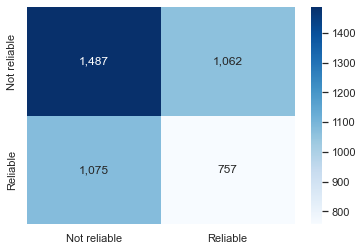

In [56]:
# Hold-out
dummy = DummyClassifier( strategy='stratified', random_state=13 )
dummy.fit( X_train, y_train )
dummy_pred = dummy.predict( X_test )

ml_metrics( y_test, dummy_pred, "Dummy" )

In [57]:
# Cross Validation
dummy = DummyClassifier( strategy='stratified', random_state=13 )

dummy_cv = cross_validation( dummy, X_train, y_train, 'Dummy' )
dummy_cv

,Model,Accuracy,Precision,Recall,F1
0,Dummy,0.51+/-0.0,0.41+/-0.0,0.4+/-0.0,0.41+/-0.0


## 7.2. Logistic Regression

Model: Logistic Regression
              precision    recall  f1-score   support

Not reliable       0.61      0.66      0.63      2549
    Reliable       0.46      0.41      0.44      1832

    accuracy                           0.56      4381
   macro avg       0.54      0.54      0.53      4381
weighted avg       0.55      0.56      0.55      4381



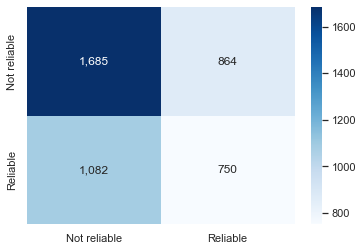

In [58]:
lr = LogisticRegression( random_state=13 )
lr.fit( X_train, y_train )
lr_pred = lr.predict( X_test )

ml_metrics( y_test, lr_pred, 'Logistic Regression' )

In [59]:
# Cross Validation
lr = LogisticRegression( random_state=13 )

lr_cv = cross_validation( lr, X_train, y_train, 'Logistic Regression' )
lr_cv

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.56+/-0.02,0.46+/-0.02,0.37+/-0.08,0.41+/-0.05


## 7.3. Decision Tree

Model: Decision Tree
              precision    recall  f1-score   support

Not reliable       0.64      0.63      0.64      2549
    Reliable       0.50      0.51      0.50      1832

    accuracy                           0.58      4381
   macro avg       0.57      0.57      0.57      4381
weighted avg       0.58      0.58      0.58      4381



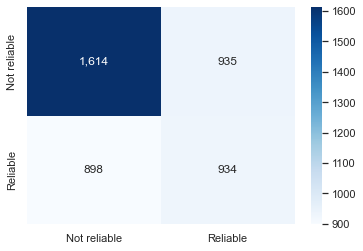

In [60]:
dt = DecisionTreeClassifier( random_state=13 )
dt.fit( X_train, y_train )
dt_prev = dt.predict( X_test )
ml_metrics( y_test, dt_prev, 'Decision Tree' )

In [61]:
# Cross Validation
dt = DecisionTreeClassifier( random_state=13 )
dt_cv = cross_validation( dt, X_train, y_train, 'Decision Tree' )
dt_cv

,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.57+/-0.01,0.48+/-0.02,0.48+/-0.02,0.48+/-0.02


## 7.4. K-Nearest Neighbors

Model: K-Nearest Neighbors
              precision    recall  f1-score   support

Not reliable       0.62      0.69      0.65      2549
    Reliable       0.48      0.40      0.44      1832

    accuracy                           0.57      4381
   macro avg       0.55      0.55      0.54      4381
weighted avg       0.56      0.57      0.56      4381



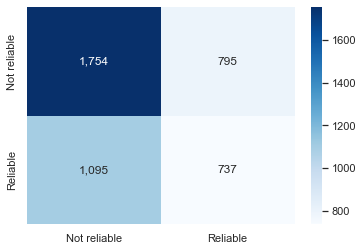

In [62]:
knn = KNeighborsClassifier()
knn.fit( X_train, y_train )
knn_prev = knn.predict( X_test )
ml_metrics( y_test, knn_prev, "K-Nearest Neighbors" )

In [63]:
# Cross Validation
knn = KNeighborsClassifier()
knn_cv = cross_validation( knn, X_train, y_train, "K-Nearest Neighbors" )
knn_cv

,Model,Accuracy,Precision,Recall,F1
0,K-Nearest Neighbors,0.57+/-0.01,0.48+/-0.01,0.4+/-0.01,0.44+/-0.01


## 7.5. Naive Bayes

Model: Naive Bayes
              precision    recall  f1-score   support

Not reliable       0.67      0.01      0.02      2549
    Reliable       0.42      0.99      0.59      1832

    accuracy                           0.42      4381
   macro avg       0.55      0.50      0.31      4381
weighted avg       0.57      0.42      0.26      4381



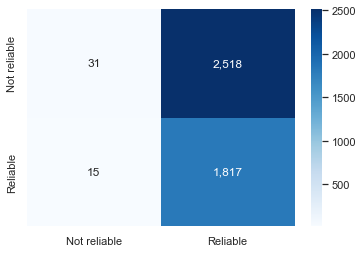

In [64]:
nb = GaussianNB()
nb.fit( X_train, y_train )
nb_pred = nb.predict( X_test )
ml_metrics( y_test, nb_pred, "Naive Bayes" )

In [65]:
# Cross Validation
nb = GaussianNB()
nb_cv = cross_validation( nb, X_train, y_train, "Naive Bayes" )
nb_cv

,Model,Accuracy,Precision,Recall,F1
0,Naive Bayes,0.42+/-0.0,0.42+/-0.0,0.99+/-0.01,0.59+/-0.0


## 7.6. Multilayer Perceptron

Model: Multilayer Perceptron
              precision    recall  f1-score   support

Not reliable       0.60      0.81      0.69      2549
    Reliable       0.48      0.25      0.33      1832

    accuracy                           0.58      4381
   macro avg       0.54      0.53      0.51      4381
weighted avg       0.55      0.58      0.54      4381



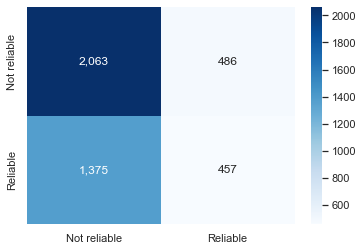

In [66]:
mlp = MLPClassifier( random_state=13 )
mlp.fit( X_train, y_train )
mlp_pred = mlp.predict( X_test )
ml_metrics( y_test, mlp_pred, "Multilayer Perceptron" )

In [67]:
# Cross Validation
mlp = MLPClassifier( random_state=13 )
mlp_cv = cross_validation( mlp, X_train, y_train, 'Multilayer Perceptron' )
mlp_cv

,Model,Accuracy,Precision,Recall,F1
0,Multilayer Perceptron,0.58+/-0.0,0.44+/-0.02,0.09+/-0.04,0.15+/-0.05


## 7.7. Random Forest

Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.66      0.81      0.73      2549
    Reliable       0.61      0.42      0.50      1832

    accuracy                           0.64      4381
   macro avg       0.63      0.61      0.61      4381
weighted avg       0.64      0.64      0.63      4381



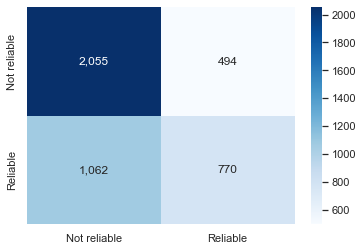

In [68]:
rf = RandomForestClassifier( random_state=13 )
rf.fit( X_train, y_train )
rf_pred = rf.predict( X_test )
ml_metrics( y_test, rf_pred, 'Random Forest')

In [69]:
# Cross Validation
rf = RandomForestClassifier( random_state=13 )
rf_cv = cross_validation( rf, X_train, y_train, 'Random Forest' )
rf_cv

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.63+/-0.01,0.57+/-0.02,0.4+/-0.02,0.47+/-0.02


## 7.8. AdaBoost Classifier

Model: AdaBoostClassifier
              precision    recall  f1-score   support

Not reliable       0.62      0.81      0.70      2549
    Reliable       0.53      0.30      0.38      1832

    accuracy                           0.59      4381
   macro avg       0.57      0.55      0.54      4381
weighted avg       0.58      0.59      0.57      4381



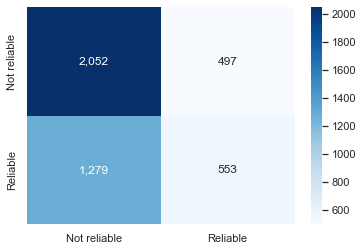

In [73]:
clf = AdaBoostClassifier()
clf.fit( X_train, y_train )
clf_pred = clf.predict( X_test )
ml_metrics( y_test, clf_pred, 'AdaBoostClassifier' )

In [74]:
# Cross Validation
clf = AdaBoostClassifier( random_state=13 )
clf_cv = cross_validation( clf, X_train, y_train, 'AdaBoostClassifier' )
clf_cv

,Model,Accuracy,Precision,Recall,F1
0,AdaBoostClassifier,0.6+/-0.01,0.52+/-0.02,0.3+/-0.01,0.38+/-0.01


## 7.9. Compare Model Performance

In [76]:
modeling_result = pd.concat( [dummy_cv, lr_cv, dt_cv, knn_cv, nb_cv, mlp_cv, rf_cv, clf_cv] )
modeling_result.sort_values( ['Precision', 'Recall'], ascending=False ).reset_index( drop=True )

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.63+/-0.01,0.57+/-0.02,0.4+/-0.02,0.47+/-0.02
1,AdaBoostClassifier,0.6+/-0.01,0.52+/-0.02,0.3+/-0.01,0.38+/-0.01
2,Decision Tree,0.57+/-0.01,0.48+/-0.02,0.48+/-0.02,0.48+/-0.02
3,K-Nearest Neighbors,0.57+/-0.01,0.48+/-0.01,0.4+/-0.01,0.44+/-0.01
4,Logistic Regression,0.56+/-0.02,0.46+/-0.02,0.37+/-0.08,0.41+/-0.05
5,Multilayer Perceptron,0.58+/-0.0,0.44+/-0.02,0.09+/-0.04,0.15+/-0.05
6,Naive Bayes,0.42+/-0.0,0.42+/-0.0,0.99+/-0.01,0.59+/-0.0
7,Dummy,0.51+/-0.0,0.41+/-0.0,0.4+/-0.0,0.41+/-0.0


# 8.0. Hyperparameter Fine Tuning

In [105]:
params = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False] }


precision2_score = make_scorer( precision_score, labels=[1], average='macro' )

search = RandomizedSearchCV(
        estimator = RandomForestClassifier( random_state=13 ),
        param_distributions=params,
        n_iter=10,
        scoring=precision2_score,
        n_jobs=-1,
        random_state=13
)

result = search.fit( X_train, y_train )
print( 'Done!' )

Done!


Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.66      0.72      0.68      2420
    Reliable       0.58      0.52      0.55      1874

    accuracy                           0.63      4294
   macro avg       0.62      0.62      0.62      4294
weighted avg       0.62      0.63      0.62      4294



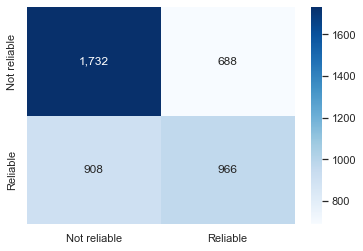

In [106]:
tuned_model = result.best_estimator_
predictions = tuned_model.predict( X_test )
ml_metrics( y_test, predictions, "Random Forest" )

# 9.0. Machine Learning Performance

In [83]:
with open( "Data/Fundamentals_final.pkl", "rb" ) as fund:
    fundamentals = pickle.load( fund )

In [87]:
df = pd.DataFrame()

for company in fundamentals:
    df = df.append( fundamentals[company][-1:] )

In [90]:
df.drop( ['Perc', 'Class'], axis=1, inplace=True )

# Fillout Na
df.fillna( 0, inplace=True )

# Feature Engineering

In [107]:
# Separating the features from the target variable
X = df_test.drop( 'Class', axis=1 )
y = df_test['Class']

Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.90      0.54      0.67       311
    Reliable       0.21      0.67      0.32        57

    accuracy                           0.56       368
   macro avg       0.55      0.60      0.50       368
weighted avg       0.79      0.56      0.62       368



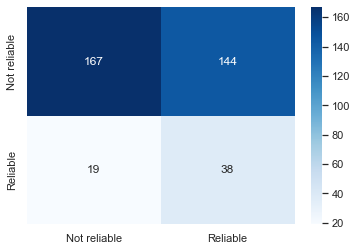

In [108]:
# Getting the predictions
test_prev = tuned_model.predict( X )

# Performance
ml_metrics( y, test_prev, "Random Forest" )

# 10.0. Deploy Model to Production

# 11.0. Conclusions